```
A) Olhando para todos os dados disponíveis na fonte http://web.antaq.gov.br/Anuario/,
em qual estrutura de banco de dados você orienta guardá-los no nosso
Data Lake? SQL ou NoSQL? Discorra sobre sua orientação.
```
A utilização de um banco de dados relacional (SQL) é o recomendado nessa situação, uma vez que os dados obtidos são dados estruturados e, além disso, estão relacionados entre si.

```
B) Nosso cliente estipulou que necessita de informações apenas sobre
as atracações e cargas contidas nessas atracações dos últimos 3 anos (2017-2019).

Desenvolva um script em python que extraia os dados do anuário, e
transforme-os em duas tabelas fato, atracacao_fato e carga_fato,
com as respectivas colunas abaixo.
```

#Bibliotecas

In [1]:
import os
import fnmatch
import urllib.request
from zipfile import ZipFile

import numpy as np
import pandas as pd

from IPython.display import display

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif','fontname': 'Times New Roman'})

#Download do conjunto de dados

In [5]:
%%time

#Escolha o Ano [2010-2021]:
Lista_Anos=[2017,2018,2019]
for Ano in Lista_Anos:
  File_zip=f'{Ano}.zip'
  url='http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/'+File_zip
  print(url,File_zip)

  if not os.path.exists(File_zip):
    File = urllib.request.urlretrieve(url, File_zip)

  z = ZipFile(File_zip, 'r')
  z.extractall()
  z.close()

http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/2017.zip 2017.zip
http://web.antaq.gov.br/Sistemas/ArquivosAnuario/Arquivos/2018.zip 2018.zip
CPU times: user 5.25 s, sys: 2 s, total: 7.24 s
Wall time: 5min 15s


In [7]:
TemposAtracacao      =fnmatch.filter(os.listdir(), '*TemposAtracacao.txt')
Atracacao            =fnmatch.filter(os.listdir(), '*Atracacao.txt')
Atracacao            =list(set(Atracacao) - set(TemposAtracacao))

Carga                =fnmatch.filter(os.listdir(), '*Carga.txt')
Carga_Conteinerizada =fnmatch.filter(os.listdir(), '*Carga_Conteinerizada.txt')

# Atracação

## Atracacao.txt

In [8]:
#Importar dataframe
L=Atracacao
df = pd.read_csv(L[0], index_col=0, sep=';')

print(L[0])
if len(L)>1:
  for f in L[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df = pd.concat([df,aux]).copy()

df_At=df.copy()
del df

2018Atracacao.txt
2017Atracacao.txt


In [9]:
df_At.reset_index(level=0,inplace=True)
df_At.sample(2)

,IDAtracacao,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Ano,Mes,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania,Nº do IMO
146153,876969,BRSSZ,SSZ0676,ARM 35.2,Santos,NaN,Santos,Porto Público,03/10/2017 14:25:00,30/09/2017 06:30:00,04/10/2017 03:40:00,03/10/2017 16:04:00,04/10/2017 01:50:00,2017,out,Movimentação da Carga,Longo Curso,2.0,1,Libra Terminais S/A,Santos,São Paulo,SP,Sudeste,NaN,9333058.0
149148,884863,BRPNG,PNG0204,Berço 204,Paranaguá,NaN,Paranaguá - Antonina,Porto Público,09/11/2017 07:05:00,06/11/2017 14:30:00,10/11/2017 09:50:00,09/11/2017 08:35:00,10/11/2017 06:40:00,2017,nov,Movimentação da Carga,Longo Curso,2.0,1,CAÍS PÚBLICO,Paranaguá,Paraná,PR,Sul,NaN,9261750.0


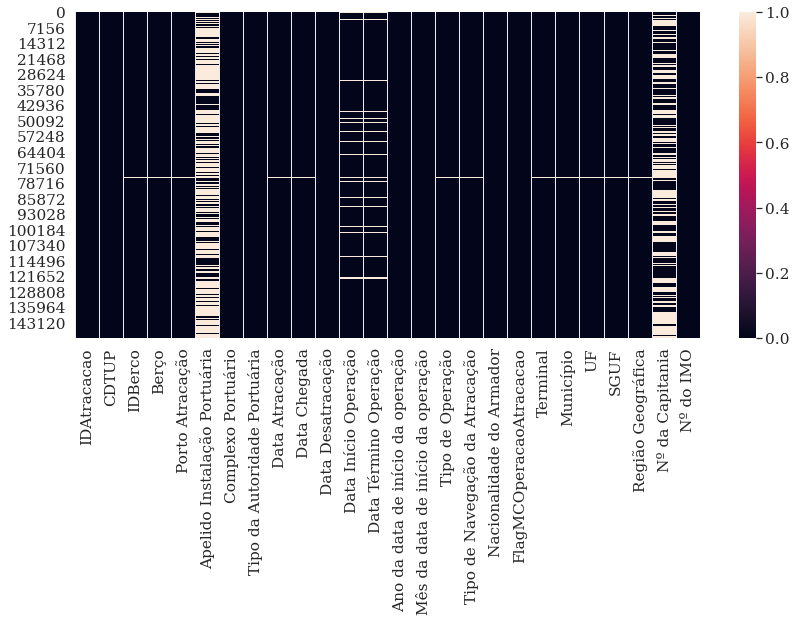

In [69]:
#Verificando valores nulos:
plt.figure(figsize=(14,6))
sns.heatmap(df_At.isnull())
plt.show()

##### Ano e Mês

Obs: Nos arquivos 'MetadadosAtracacao.txt' e 'MetadadosTemposAtracacao.txt' não encontrei informações sobre as colunas 'Ano' e 'Mes' presentes nos arquivos '2017Atracacao.txt', '2018Atracacao.txt', etc.

Já, no arquivo 'Projeto -  Engenheiro de dados.pdf', são apresentadas as colunas 'Mês da data de início da operação' e 'Ano da data de início da operação'.

Entretanto, como se pode ver no Exemplo 1 abaixo, supondo que este dado esteja correto, o 'Mes' é diferente do mês da 'Data Início Operação', provavelmente se refere ao mês ou da 'Data Desatracação' ou da 'Data Término Operação'.
Por outro lado, no Exemplo 2 (assim como em muitos outros casos), a única data presente é a 'Data Desatracação'.

Portanto, faz mais sentido que 'Mes' e 'Ano' se refiram à 'Data Desatracação'.

In [10]:
#Exemplo 1:
filtro=df_At['IDAtracacao']==1033424
df_At.loc[filtro,['IDAtracacao','Data Atracação','Data Desatracação','Data Início Operação','Data Término Operação','Mes','Ano']]

,IDAtracacao,Data Atracação,Data Desatracação,Data Início Operação,Data Término Operação,Mes,Ano
76078,1033424,26/11/2018 21:36:00,01/12/2018 10:02:00,26/11/2018 21:37:00,01/12/2018 10:01:00,dez,2018


In [11]:
#Exemplo 2:
filtro=df_At['IDAtracacao']==2487
df_At.loc[filtro,['IDAtracacao','Data Atracação','Data Desatracação','Data Início Operação','Data Término Operação','Mes','Ano']]

,IDAtracacao,Data Atracação,Data Desatracação,Data Início Operação,Data Término Operação,Mes,Ano
1,2487,NaN,01/10/2018 00:00:00,NaN,NaN,out,2018


De qualquer forma, renomei as colunas 'Mes' e 'Ano' para ficarem de acordo com o pdf.

In [12]:
df_At=df_At.rename(columns={"Mes": "Mês da data de início da operação", "Ano": "Ano da data de início da operação"})

##### 'Nº do IMO'

In [13]:
#Uma que zero não é um 'Nº do IMO' válido e são inteiros...
#Trocar NaN por 0 e Converter float para int:
df_At['Nº do IMO']=df_At['Nº do IMO'].fillna(0).astype('int64')

##### Trocar tipo de algumas colunas para categoria

In [14]:
display( df_At['Nacionalidade do Armador'].astype('category').unique() )

#Trocar NaN por 0, considerando 0 quando o valor (1|2) não é informado:
df_At['Nacionalidade do Armador']=df_At['Nacionalidade do Armador'].fillna(0).map(lambda v:int(v))

display( df_At['Nacionalidade do Armador'].astype('category').unique() )

[NaN, 0.0, 2.0, 1.0]
Categories (3, float64): [0.0, 2.0, 1.0]

[0, 2, 1]
Categories (3, int64): [0, 2, 1]

In [15]:
Lista=['Tipo da Autoridade Portuária','Tipo de Operação', 'Tipo de Navegação da Atracação',
       'Nacionalidade do Armador', 'FlagMCOperacaoAtracacao','UF', 'SGUF', 'Região Geográfica',
       'Mês da data de início da operação']

#Altera tipo objetos_string para categoria:
for col in Lista:
  df_At[col]= df_At[col].astype('category')

In [16]:
df_At['Mês da data de início da operação'].cat.reorder_categories(['jan','fev','mar','abr',
                                                                   'mai','jun','jul','ago',
                                                                   'set','out','nov','dez'],
                                                                   ordered=True, inplace=True)

In [17]:
df_At['Mês da data de início da operação'].unique()

['set', 'out', 'ago', 'abr', 'jan', ..., 'nov', 'fev', 'dez', 'jun', 'jul']
Length: 12
Categories (12, object): ['jan' < 'fev' < 'mar' < 'abr' ... 'set' < 'out' < 'nov' < 'dez']

In [18]:
df_At.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150264 entries, 0 to 150263
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   IDAtracacao                        150264 non-null  int64   
 1   CDTUP                              150264 non-null  object  
 2   IDBerco                            149506 non-null  object  
 3   Berço                              149506 non-null  object  
 4   Porto Atracação                    149506 non-null  object  
 5   Apelido Instalação Portuária       55136 non-null   object  
 6   Complexo Portuário                 150264 non-null  object  
 7   Tipo da Autoridade Portuária       150264 non-null  category
 8   Data Atracação                     149506 non-null  object  
 9   Data Chegada                       149506 non-null  object  
 10  Data Desatracação                  150264 non-null  object  
 11  Data Início Operação      

## TemposAtracacao.txt

In [19]:
#Importar dataframe
L=TemposAtracacao
df = pd.read_csv(L[0], index_col=0, sep=';')

print(L[0])
if len(L)>1:
  for f in L[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df = pd.concat([df,aux]).copy()

df_time_At=df.copy()
del df

2017TemposAtracacao.txt
2018TemposAtracacao.txt


In [20]:
df_time_At.reset_index(level=0,inplace=True)
df_time_At.sample(2)

,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
116652,937370,0,0,"5,7666666667792",0,"5,7666666667792","5,7666666667792"
70379,878170,"26,833333333314","0,16666666668607","5,7499999998836","0,66666666674428","6,5833333333139","33,416666666628"


In [21]:
#Trocar ',' por '.' e Converter em object/string em float:
for col in df_time_At.columns[df_time_At.dtypes=='object']:
  df_time_At[col]=df_time_At[col].astype('str').map( lambda v: v.replace(',','.') ).astype('float64')

In [22]:
#Alguns valores da tabela podem ser exibidos como se tivessem sido arredondados,
#mas note que isso é somente na exibição pois os valores não foram alterados:
display( df_time_At.query('IDAtracacao==892942') )
display( df_time_At.query('IDAtracacao==892942').astype('str') )

,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
149399,892942,1.0,0.0,0.0,0.0,23.0,24.0


,IDAtracacao,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
149399,892942,0.99999999994179,0.0,0.0,0.0,23.000000000058,24.0


## Tabela atracacao_fato

In [23]:
atracacao_fato = pd.merge(df_At, df_time_At, how="left", on="IDAtracacao")
atracacao_fato = atracacao_fato.sort_values(by=['IDAtracacao'], ignore_index=True)
atracacao_fato.sample(4)

,IDAtracacao,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Ano da data de início da operação,Mês da data de início da operação,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania,Nº do IMO,TEsperaAtracacao,TEsperaInicioOp,TOperacao,TEsperaDesatracacao,TAtracado,TEstadia
9215,939983,BRSFS,SFS0302,BRA302,São Francisco do Sul,NaN,São Francisco do Sul,Porto Público,13/07/2018 16:30:00,13/07/2018 12:50:00,16/07/2018 13:45:00,13/07/2018 16:50:00,16/07/2018 13:30:00,2018,jul,Movimentação da Carga,Cabotagem,1,1,TESC,São Francisco do Sul,Santa Catarina,SC,Sul,NaN,9164809,3.666667,0.333333,68.666667,0.250000,69.250000,72.916667
135359,879973,BRGO001,BRGO0010001,SSI01,LDC São Simão,NaN,São Simão,Porto Privado,18/11/2017 18:47:00,18/11/2017 18:47:00,18/11/2017 20:39:00,18/11/2017 18:47:00,18/11/2017 20:39:00,2017,nov,Movimentação da Carga,Interior,1,1,LDC São Simão,São Simão,Goiás,GO,Centro-Oeste,4050185091,0,0.000000,0.000000,1.866667,0.000000,1.866667,1.866667
87572,830632,BRFOR,FOR0401,Berço 201,Fortaleza,Mucuripe,Pecém - Fortaleza,Porto Público,07/03/2017 20:50:00,06/03/2017 16:00:00,11/03/2017 02:25:00,07/03/2017 20:50:00,11/03/2017 02:25:00,2017,mar,Movimentação da Carga,Cabotagem,2,1,Píer Petroleiro,Fortaleza,Ceará,CE,Nordeste,3813904768,9596856,28.833333,0.000000,77.583333,0.000000,77.583333,106.416667
111923,845830,BRSSZ,SSZ0910,AGEO I,Santos,NaN,Santos,Porto Público,20/02/2017 17:15:00,13/02/2017 15:42:00,24/02/2017 11:15:00,21/02/2017 02:15:00,24/02/2017 00:40:00,2017,fev,Movimentação da Carga,Longo Curso,2,1,Cais Público - Ilha Barnabé,Santos,São Paulo,SP,Sudeste,NaN,9125243,169.550000,9.000000,70.416667,10.583333,90.000000,259.550000


In [26]:
atracacao_fato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150264 entries, 0 to 150263
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   IDAtracacao                        150264 non-null  int64   
 1   CDTUP                              150264 non-null  object  
 2   IDBerco                            149506 non-null  object  
 3   Berço                              149506 non-null  object  
 4   Porto Atracação                    149506 non-null  object  
 5   Apelido Instalação Portuária       55136 non-null   object  
 6   Complexo Portuário                 150264 non-null  object  
 7   Tipo da Autoridade Portuária       150264 non-null  category
 8   Data Atracação                     149506 non-null  object  
 9   Data Chegada                       149506 non-null  object  
 10  Data Desatracação                  150264 non-null  object  
 11  Data Início Operação      

In [27]:
atracacao_fato.describe(include=['object','category'])

,CDTUP,IDBerco,Berço,Porto Atracação,Apelido Instalação Portuária,Complexo Portuário,Tipo da Autoridade Portuária,Data Atracação,Data Chegada,Data Desatracação,Data Início Operação,Data Término Operação,Mês da data de início da operação,Tipo de Operação,Tipo de Navegação da Atracação,Nacionalidade do Armador,FlagMCOperacaoAtracacao,Terminal,Município,UF,SGUF,Região Geográfica,Nº da Capitania
count,150264,149506,149506,149506,55136,150264,150264,149506,149506,150264,142645,142642,150264,149506,149506,150264,150264,149506,149506,149506,149506,149506,85835
unique,195,627,510,194,74,40,2,112643,91612,111507,110378,109706,12,8,5,3,1,266,80,21,21,5,2524
top,BRSSZ,BEL0006,6F,Santos,Terminal Alfandegado de Imbetiba - TAI,Vila do Conde - Belém,Porto Privado,01/09/2018 00:01:00,01/01/2016 00:01:00,01/06/2017 00:00:00,17/02/2018 07:00:00,17/02/2018 19:00:00,ago,Movimentação da Carga,Interior,1,1,Cais Público,Belém,Pará,PA,Norte,0210254220
freq,9724,5426,5426,9724,4140,18689,83346,26,230,40,20,20,13393,119028,71050,96269,150264,18691,12753,30625,30625,59705,926


In [70]:
#Escrever tabela em arquivo CSV:
atracacao_fato.to_csv('Tabela_atracacao_fato.csv', index=False)

# Carga

### Carga.txt

In [28]:
#Importar dataframe
df_Carga = pd.read_csv(Carga[0], index_col=0, sep=';')

print(Carga[0])
if len(Carga)>1:
  for f in Carga[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df_Carga = pd.concat([df_Carga,aux]).copy()

2017Carga.txt
2018Carga.txt


In [29]:
df_Carga.reset_index(level=0,inplace=True)

In [30]:
df_Carga.sample(2)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta
3808243,23248279,962927,BRPNG,MXVER,22G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,20,1.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,6,6,"78,505"
3966005,23408357,969745,BRAM001,BRPA013,SRFC,Interior,Solta,NaN,Interior,S,0.0,0.0,NaN,0.0,1,0.0,1,Interior Interestadual,Navegação Interior,Exclusivo,Compartilhado,Compartilhado,Carga Geral,Desembarcados,0,1,"15,356"


____________
Corrigir colunas (Alterar tipo, Substituir ',' por '.'):

In [31]:
Lista=['STNaturezaCarga', 'STSH2', 'STSH4', 'Natureza da Carga', 'Sentido',
       'Tipo Navegação', 'Carga Geral Acondicionamento', 'ConteinerEstado',
       'Tipo Operação da Carga', 'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'FlagAutorizacao']

#Altera tipo objetos_string para categoria:
for col in Lista:
  df_Carga[col] = df_Carga[col].astype('category')

In [32]:
df_Carga['TEU']=df_Carga['TEU'].map(lambda v:str(v)).map(lambda v:v.replace(',','.')).map(lambda v:float(v))

In [33]:
df_Carga['VLPesoCargaBruta']=df_Carga['VLPesoCargaBruta'].map(lambda v:v.replace(',','.')).map(lambda v:float(v))

In [34]:
%%time

df_Carga['FlagConteinerTamanho']=df_Carga['FlagConteinerTamanho'].map(lambda v:str(v)).map(lambda v:v.replace('.0',''))

Lista=[]
for idx in df_Carga.index:
  aux=df_Carga.loc[idx,'FlagConteinerTamanho']
  #if str(aux)=='nan': aux=np.nan
  if aux=='nan': aux=np.nan
  Lista.append( aux )

df_Carga['FlagConteinerTamanho']=pd.Series(Lista).astype('category')

CPU times: user 1min 13s, sys: 172 ms, total: 1min 13s
Wall time: 1min 13s


____________

In [35]:
df_Carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4093051 entries, 0 to 4093050
Data columns (total 27 columns):
 #   Column                                  Dtype   
---  ------                                  -----   
 0   IDCarga                                 int64   
 1   IDAtracacao                             int64   
 2   Origem                                  object  
 3   Destino                                 object  
 4   CDMercadoria                            object  
 5   Tipo Operação da Carga                  category
 6   Carga Geral Acondicionamento            category
 7   ConteinerEstado                         category
 8   Tipo Navegação                          category
 9   FlagAutorizacao                         category
 10  FlagCabotagem                           float64 
 11  FlagCabotagemMovimentacao               float64 
 12  FlagConteinerTamanho                    category
 13  FlagLongoCurso                          float64 
 14  FlagMCOperacaoCarg

### Carga_Conteinerizada.txt

In [36]:
#Importar dataframe
df_CargaC = pd.read_csv(Carga_Conteinerizada[0], index_col=0, sep=';')

print(Carga_Conteinerizada[0])
if len(Carga_Conteinerizada)>1:
  for f in Carga_Conteinerizada[1:]:
    print(f)
    aux = pd.read_csv(f, index_col=0, sep=';')
    df_CargaC = pd.concat([df_CargaC,aux]).copy()

2018Carga_Conteinerizada.txt
2017Carga_Conteinerizada.txt


In [37]:
df_CargaC.reset_index(level=0,inplace=True)
df_CargaC.sample(2)

,IDCarga,CDMercadoriaConteinerizada,VLPesoCargaConteinerizada
3397394,22010404,8708,"0,77"
2169097,21595630,5806,"0,96"


In [38]:
#Trocar ',' por '.':
df_CargaC=df_CargaC.assign( VLPesoCargaConteinerizada = df_CargaC['VLPesoCargaConteinerizada'].astype('str').map( lambda v: v.replace(',','.') ) )

#Converter em object/string em float:
df_CargaC['VLPesoCargaConteinerizada']=df_CargaC['VLPesoCargaConteinerizada'].astype('float64')

In [ ]:
df_CargaC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7045250 entries, 0 to 7045249
Data columns (total 3 columns):
IDCarga                       int64
CDMercadoriaConteinerizada    object
VLPesoCargaConteinerizada     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 161.3+ MB


In [39]:
#Possui valores nulos?
df_CargaC.isnull().any()

IDCarga                       False
CDMercadoriaConteinerizada    False
VLPesoCargaConteinerizada     False
dtype: bool

In [40]:
%%time
df_CargaC_group=df_CargaC.groupby(['IDCarga']).agg({'CDMercadoriaConteinerizada':'unique','VLPesoCargaConteinerizada':'sum'})

CPU times: user 4min 36s, sys: 11.9 s, total: 4min 48s
Wall time: 4min 29s


In [ ]:
df_CargaC_group=df_CargaC_group.rename(columns={'VLPesoCargaConteinerizada':'sumVLPesoCargaConteinerizada'})

In [44]:
df_CargaC_group.reset_index(level=0,inplace=True)
df_CargaC_group

,IDCarga,CDMercadoriaConteinerizada,sumVLPesoCargaConteinerizada
0,17765801,[4409],19.31
1,17765802,[4409],21.00
2,17765803,[0511],3.34
3,17765804,[0904],10.82
4,17765805,[4409],21.86
...,...,...,...
3501232,27705307,[0904],24.93
3501233,27705308,[0904],24.89
3501234,27705309,[0904],25.15
3501235,27705310,[0904],25.15


In [45]:
df_CargaC_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3501237 entries, 0 to 3501236
Data columns (total 3 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   IDCarga                       int64  
 1   CDMercadoriaConteinerizada    object 
 2   sumVLPesoCargaConteinerizada  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 80.1+ MB


## Tabela carga_fato

In [46]:
atracacao_fato_part=atracacao_fato[['IDAtracacao','Ano da data de início da operação',
                                    'Mês da data de início da operação','Porto Atracação','SGUF']]
atracacao_fato_part=atracacao_fato_part.rename(columns={'Mês da data de início da operação':'Mês da data de início da operação da atracação',
                                                        'Ano da data de início da operação':'Ano da data de início da operação da atracação'})

atracacao_fato_part

,IDAtracacao,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF
0,2462,2018,set,NaN,NaN
1,2487,2018,out,NaN,NaN
2,2474,2018,out,NaN,NaN
3,2489,2018,out,NaN,NaN
4,2488,2018,out,NaN,NaN
...,...,...,...,...,...
150259,943303,2017,mar,Terminal Santa Clara,RS
150260,943346,2017,ago,Terminal Santa Clara,RS
150261,943343,2017,jul,Terminal Santa Clara,RS
150262,943304,2017,mar,Terminal Santa Clara,RS


In [47]:
Carga_At = pd.merge(df_Carga, atracacao_fato_part, how="left", on="IDAtracacao")
Carga_At = Carga_At.sort_values(by=['IDCarga'], ignore_index=True)

#Carga_At.sample(12)
Carga_At

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF
0,118,118,BRQGA,BRQGA,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,66000.00,2017,jan,NaN,NaN
1,119,119,BRQGA,BR373,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Interestadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,9900.00,2017,jan,NaN,NaN
2,120,120,BRQGA,BR375,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,26400.00,2017,jan,NaN,NaN
3,128,128,BRQGA,PYZ06,3102,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,1425.90,2017,jan,NaN,NaN
4,177,177,BRQGA,PYZ06,2521,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,688.01,2017,jan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093046,27705307,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.73,2018,dez,Vila do Conde,PA
4093047,27705308,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.69,2018,dez,Vila do Conde,PA
4093048,27705309,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA
4093049,27705310,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA


In [49]:
carga_fato = pd.merge(Carga_At, df_CargaC_group, how="left", on="IDCarga")
carga_fato = carga_fato.sort_values(by=['IDCarga'], ignore_index=True)
carga_fato

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,CDMercadoriaConteinerizada,sumVLPesoCargaConteinerizada
0,118,118,BRQGA,BRQGA,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,66000.00,2017,jan,NaN,NaN,NaN,NaN
1,119,119,BRQGA,BR373,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Interestadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,9900.00,2017,jan,NaN,NaN,NaN,NaN
2,120,120,BRQGA,BR375,2505,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Estadual,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,26400.00,2017,jan,NaN,NaN,NaN,NaN
3,128,128,BRQGA,PYZ06,3102,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,1425.90,2017,jan,NaN,NaN,NaN,NaN
4,177,177,BRQGA,PYZ06,2521,NaN,NaN,NaN,Interior,N,NaN,NaN,NaN,NaN,1,NaN,1,Interior Internacional,Navegação Interior,Compartilhado,Compartilhado,Compartilhado,Granel Sólido,Desembarcados,0.0,0,688.01,2017,jan,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093046,27705307,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.73,2018,dez,Vila do Conde,PA,[0904],24.93
4093047,27705308,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.69,2018,dez,Vila do Conde,PA,[0904],24.89
4093048,27705309,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA,[0904],25.15
4093049,27705310,1133637,BRVDC,VNSGN,45G0,Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,1,NaN,Longo Curso em vias interiores,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.95,2018,dez,Vila do Conde,PA,[0904],25.15


#### Coluna 'CDMercadoria'

```
CDMercadoria = {CDMercadoria:[Lista de código das mercadorias dentro do contêiner]} if carga conteinerizada
             = CDMercadoria                                                         if carga não conteinerizada
```

In [50]:
#Há elementos nulos?
carga_fato['CDMercadoria'].isnull().any()

False

No arquivo '{ano}carga.txt' de algum {ano} específico está presente a coluna 'CDMercadoria' que não possui nenhum valor ausente.

Pede-se que seja criada a tabela 'carga_fato' com a coluna 'CDMercadoria' onde se lê a seguinte observação: (Para carga conteinerizada informar código das mercadorias dentro do contêiner.).

Considerando que a tabela 'carga_fato' deve conter APENAS as colunas apresentadas na questão e nenhuma outra, uma possível solução para isso, é criar um dicionário ({key:value}) com o valor 'CDMercadoria' como chave e uma lista contendo os códigos 'CDMercadoriaConteinerizada' correspondentes como valor.

Destaco aqui que algumas cargas conteinerizadas não possuem os códigos das mercadorias.

In [54]:
filtro=(carga_fato['CDMercadoriaConteinerizada'].isnull()) & (carga_fato['Carga Geral Acondicionamento'].notnull()) #254819 rows
carga_fato.loc[filtro,['IDCarga','CDMercadoria','CDMercadoriaConteinerizada','Carga Geral Acondicionamento','ConteinerEstado']]

,IDCarga,CDMercadoria,CDMercadoriaConteinerizada,Carga Geral Acondicionamento,ConteinerEstado
759,17713375,CA01,NaN,Solta,NaN
775,17717423,7208,NaN,Solta,NaN
776,17717430,7208,NaN,Solta,NaN
938,17766920,7208,NaN,Solta,NaN
962,17774302,7210,NaN,Solta,NaN
...,...,...,...,...,...
4090646,24054964,45R0,NaN,Conteinerizada,NaN
4091031,24055349,49G9,NaN,Conteinerizada,NaN
4091032,24055350,49G9,NaN,Conteinerizada,NaN
4091033,24055351,49G9,NaN,Conteinerizada,NaN


In [55]:
%%time
Lista=[]
for idx in carga_fato.index:
  aux=carga_fato.loc[idx,'CDMercadoriaConteinerizada']
  if str(aux)=='nan': aux=''
  Lista.append( {carga_fato.loc[idx,'CDMercadoria']:aux} )

CPU times: user 3min 57s, sys: 2.56 s, total: 4min
Wall time: 4min


In [57]:
carga_fato.insert(4, 'CDMercadoria2', pd.Series(Lista))

carga_fato=carga_fato.drop(columns=['CDMercadoria', 'CDMercadoriaConteinerizada'])

carga_fato.rename(columns={'CDMercadoria2':'CDMercadoria'},inplace=True)

In [59]:
carga_fato.sample(3)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,sumVLPesoCargaConteinerizada
1127591,20113918,869831,BRITJ,BRCE001,{'45G0': ['4804']},Movimentação de Carga,Conteinerizada,Cheio,Cabotagem,S,1.0,1.0,40,0.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,2.0,1,30.008,2017,ago,Terminal Portuário do Pecém,CE,25.99
4006737,23449090,971382,BRSC008,ESBCN,{'42G0': ['4407']},Longo Curso Exportação,Conteinerizada,Cheio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,28.940,2018,dez,Portonave - Terminais Portuários de Navegantes,SC,25.00
1826684,21090926,905143,BRSSZ,BRSUA,{'45G0': [7306]},Longo Curso Importação com Baldeação de Carga ...,Conteinerizada,Cheio,Cabotagem,S,0.0,1.0,40,0.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Embarcados,2.0,1,23.760,2018,fev,Santos,SP,19.93


#### Coluna 'Peso líquido da carga'

```
Peso líquido da carga = 'Peso bruto'         if Carga não conteinerizada 
                      = 'Peso sem contêiner' if Carga conteinerizada

'Peso líquido da carga' = 'VLPesoCargaBruta'               if 'Carga Geral Acondicionamento' == 'Solta'
                        = [Sum]'VLPesoCargaConteinerizada' if 'Carga Geral Acondicionamento' == 'Conteinerizada'
                        = 'VLPesoCargaBruta'               if 'Carga Geral Acondicionamento' ==  NaN
```

In [62]:
#Há algum valor nulo?
carga_fato['VLPesoCargaBruta'].isnull().any()

False

In [64]:
%%time
List=[]
for idx in carga_fato.index:
  if carga_fato.loc[idx,'Carga Geral Acondicionamento'] == 'Conteinerizada':
    value=carga_fato.loc[idx,'sumVLPesoCargaConteinerizada']
  else:
    value=carga_fato.loc[idx,'VLPesoCargaBruta']
  List.append( value )

CPU times: user 2min 47s, sys: 678 ms, total: 2min 47s
Wall time: 2min 47s


In [66]:
carga_fato['Peso líquido da carga']=pd.Series(List)

carga_fato.drop(columns=['sumVLPesoCargaConteinerizada'],inplace=True)

In [67]:
carga_fato.sample(2)

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagConteinerTamanho,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano da data de início da operação da atracação,Mês da data de início da operação da atracação,Porto Atracação,SGUF,Peso líquido da carga
2864689,22226051,930997,ZADUR,BRITJ,{'45R0': ['45R0']},Longo Curso Importação,Conteinerizada,Vazio,Longo Curso,S,0.0,0.0,40,1.0,1,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Desembarcados,2.0,1,4.00,2018,jun,Itajaí,SC,0.00
911119,19802333,859282,NaN,NaN,{'22G1': ['1005']},Safamento,Conteinerizada,Cheio,Não Indentificado,S,0.0,0.0,20,0.0,0,0.0,0,NaN,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,Não Informado,1.0,1,32.28,2017,jul,Salvador,BA,30.06


________________________

In [71]:
#Escrever tabela em arquivo CSV:
carga_fato.to_csv('Tabela_carga_fato.csv', index=False)

# Armazenando tabelas em Banco de Dados
________________________

In [91]:
from sqlalchemy import create_engine

In [92]:
eng = create_engine('sqlite:///Banco_Dados.db')

In [93]:
atracacao_fato.to_sql('atracacao_fato', con=eng, index=False)
#carga_fato.to_sql('carga_fato',con=eng, index=False)

#con.commit()

In [94]:
eng.execute('SELECT * FROM atracacao_fato LIMIT 10000,10').fetchall()

[(987590, 'BRCE001', 'BRCE0015008', 'TMUT-B8', 'Terminal Portuário do Pecém', None, 'Pecém - Fortaleza', 'Porto Privado', '03/12/2018 20:59:00', '03/12/2018 19:12:00', '04/12/2018 09:35:00', '03/12/2018 22:00:00', '04/12/2018 08:40:00', 2018, 'dez', 'Movimentação da Carga', 'Cabotagem', '2', '1', 'Terminal Portuário do Pecém', 'São Gonçalo do Amarante', 'Ceará', 'CE', 'Nordeste', None, 9307839, 1.7833333332092, 1.0166666666628, 10.666666666686, 0.91666666668607, 12.600000000035, 14.383333333244),
 (911072, 'BRITJ', 'ITJ0102', 'APTM 2', 'Itajaí', None, 'Itajaí', 'Porto Público', '02/03/2018 15:05:00', '28/02/2018 07:48:00', '03/03/2018 11:15:00', '02/03/2018 16:00:00', '03/03/2018 04:12:00', 2018, 'mar', 'Movimentação da Carga', 'Longo Curso', '2', '1', 'Cais Arrendado', 'Itajaí', 'Santa Catarina', 'SC', 'Sul', None, 9307839, 55.283333333326, 0.91666666668607, 12.200000000128, 7.0499999999302, 20.166666666744, 75.45000000007),
 (937804, 'BRSSA', 'SSA0611', 'TECON', 'Salvador', None, 'Ar

In [106]:
eng.execute('SELECT * FROM atracacao_fato WHERE IDAtracacao=954497').fetchall()

[(954497, 'BRBEL', 'BEL0001', '01', 'Belém', None, 'Vila do Conde - Belém', 'Porto Público', '21/09/2018 07:35:00', '21/09/2018 07:00:00', '21/09/2018 10:36:00', '21/09/2018 07:45:00', '21/09/2018 10:00:00', 2018, 'set', 'Apoio', 'Apoio Portuário', '1', '1', 'Cais Público', 'Belém', 'Pará', 'PA', 'Norte', '0210226544', 0, 0.58333333331393, 0.16666666668607, 2.25, 0.60000000003492, 3.016666666721, 3.6000000000349)]

______________

```
C) Crie uma consulta (query) otimizada em sql para rodar no excel e que, por isso, tenha o menor número de linhas possível para
não travar o programa.
A consulta deve retornar uma tabela com dados do Ceará, Nordeste e Brasil contendo número de atracações, para cada localidade,
bem como tempo de espera para atracar e tempo atracado por meses nos anos de 2018 e 2019.
```

In [153]:
#Localidades = Municípios do Ceará
eng.execute("""
SELECT DISTINCT Município as Localidade,
                Count(IDAtracacao) as 'Número de Atracações',
                [Mês da data de início da operação] as Mês,
                [Ano da data de início da operação] as Ano,
                AVG(TEsperaAtracacao) as 'Tempo de espera médio',
                AVG(TAtracado) as 'Tempo atracado médio'
FROM atracacao_fato
WHERE SGUF='CE' AND (Ano=2018 OR Ano=2017)
GROUP BY Localidade,Mês,Ano
""").fetchall()

[('Fortaleza', 49, 'abr', 2017, 34.42619047618507, 55.86938775510486),
 ('Fortaleza', 51, 'abr', 2018, 31.35849673202378, 57.82777777779169),
 ('Fortaleza', 51, 'ago', 2017, 25.898366013076195, 47.10947712419062),
 ('Fortaleza', 56, 'ago', 2018, 28.650892857166976, 46.774999999988964),
 ('Fortaleza', 51, 'dez', 2017, 21.139869281046334, 49.51960784315321),
 ('Fortaleza', 56, 'dez', 2018, 34.34761904761497, 52.39017857142941),
 ('Fortaleza', 56, 'fev', 2017, 22.08750000001499, 47.065773809519044),
 ('Fortaleza', 59, 'fev', 2018, 25.29632768362388, 40.03559322032867),
 ('Fortaleza', 45, 'jan', 2017, 15.500740740731509, 56.74222222223955),
 ('Fortaleza', 61, 'jan', 2018, 40.69426229509123, 36.48415300545385),
 ('Fortaleza', 62, 'jul', 2017, 24.575806451622444, 47.33440860213573),
 ('Fortaleza', 51, 'jul', 2018, 16.99052287582374, 58.82908496731759),
 ('Fortaleza', 52, 'jun', 2017, 16.844230769254775, 45.83429487178088),
 ('Fortaleza', 48, 'jun', 2018, 22.57430555557596, 46.88923611108847)

In [154]:
#Localidades = Municípios do Nordeste
eng.execute("""
SELECT DISTINCT Município as Localidade,
                Count(IDAtracacao) as 'Número de Atracações',
                [Mês da data de início da operação] as Mês,
                [Ano da data de início da operação] as Ano,
                AVG(TEsperaAtracacao) as 'Tempo de espera médio',
                AVG(TAtracado) as 'Tempo atracado médio'
FROM atracacao_fato
WHERE [Região Geográfica]='Nordeste' AND (Ano=2018 OR Ano=2017)
GROUP BY Localidade,Mês,Ano
""").fetchall()

[('Aracaju', 3, 'abr', 2017, 24.8666666666977, 26.166666666686),
 ('Aracaju', 2, 'abr', 2018, 24.583333333401, 33.499999999970996),
 ('Aracaju', 4, 'ago', 2017, 32.0000000000145, 46.474999999963245),
 ('Aracaju', 2, 'ago', 2018, 27.666666666744, 35.374999999971),
 ('Aracaju', 3, 'dez', 2017, 7.9333333333489335, 22.699999999953665),
 ('Aracaju', 1, 'dez', 2018, 12.83333333343, 41.583333333372),
 ('Aracaju', 3, 'fev', 2017, 12.433333333290667, 27.466666666616003),
 ('Aracaju', 2, 'fev', 2018, 4.79999999993015, 28.325000000128),
 ('Aracaju', 2, 'jan', 2017, 4.34999999994765, 21.9000000000525),
 ('Aracaju', 3, 'jan', 2018, 20.9444444444961, 61.105555555550325),
 ('Aracaju', 3, 'jul', 2017, 61.766666666664, 47.56666666670933),
 ('Aracaju', 1, 'jul', 2018, 51.75, 25.916666666628),
 ('Aracaju', 2, 'jun', 2017, 12.8000000000757, 19.999999999971003),
 ('Aracaju', 1, 'jun', 2018, 23.499999999942, 38.25),
 ('Aracaju', 4, 'mai', 2017, 60.99999999998545, 41.075000000040504),
 ('Aracaju', 2, 'mai', 

In [127]:
#Localidades = Municípios do Brasil
eng.execute("""
SELECT DISTINCT Município as Localidade,
                Count(IDAtracacao) as 'Número de Atracações',
                [Mês da data de início da operação] as Mês,
                [Ano da data de início da operação] as Ano,
                AVG(TEsperaAtracacao) as 'Tempo de espera médio',
                AVG(TAtracado) as 'Tempo atracado médio'
FROM atracacao_fato
WHERE (Ano=2018 OR Ano=2017)
GROUP BY Localidade,Mês,Ano
LIMIT 30,30
""").fetchall()

[('Almeirim', 2, 'dez', 2017, 0.9500000000407399, 76.874999999999),
 ('Almeirim', 4, 'dez', 2018, 0.875000000058205, 97.31249999995599),
 ('Almeirim', 3, 'fev', 2017, 1.0277777778101134, 40.305555555562),
 ('Almeirim', 3, 'fev', 2018, 0.8055555555038133, 115.75),
 ('Almeirim', 3, 'jan', 2017, 0.83333333331393, 147.25),
 ('Almeirim', 3, 'jan', 2018, 0.7222222221898833, 28.166666666686),
 ('Almeirim', 7, 'jul', 2017, 1.4547619047641258, 68.25952380953028),
 ('Almeirim', 2, 'jul', 2018, 0.98333333330811, 33.75),
 ('Almeirim', 4, 'jun', 2018, 0.8749999999708951, 116.00000000001549),
 ('Almeirim', 4, 'mai', 2017, 1.1250000000436449, 60.354166666598),
 ('Almeirim', 3, 'mai', 2018, 0.83333333331393, 27.03333333332567),
 ('Almeirim', 4, 'mar', 2017, 0.916666666686075, 85.95833333334201),
 ('Almeirim', 5, 'mar', 2018, 0.963333333295304, 96.16999999999621),
 ('Almeirim', 2, 'nov', 2017, 1.249999999970895, 101.750000000059),
 ('Almeirim', 3, 'nov', 2018, 1.2000000000116369, 66.00000000000067),
 (

____________________
____________________